In [39]:
import glob, os, sys, random
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
from shapely import geometry
import numpy as np

In [2]:
files = glob.glob('../data/iea_balances_public/*')

In [3]:
iso2 = pd.read_csv('../data/iso2.csv')

In [4]:
fiona.listlayers('../data/GHSL_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_1.gpkg')

['GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_1']

In [5]:
ghsl_gdf = gpd.read_file('../data/GHSL_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_1.gpkg')

In [6]:
ne = gpd.read_file('../data/ne/ne_10m_countries.gpkg')

In [7]:
ghsl_gdf.GDP15_SM

0        5369555456
1        1881494016
2        4434151424
3         872692416
4        1209973248
            ...    
13130    1019849024
13131    3498342656
13132    1449215488
13133     975898880
13134             0
Name: GDP15_SM, Length: 13135, dtype: object

Want to add to the ghsl: 
- oil, gas, coal cons.
1. Need to expand the area of ghsl to include all of the given country. Creates a df with urban+rural populations
  - within each country, geovoronoi all the coords of each urban area. cascade union to get large urban+rural zones, add rural area back to dataframe. Can assume all rural popdens is the same per country, get rural pop from iso2
2. for each urban+rural combo, need to calculate oil, gas, and coal consumption. Parametrically estimate from Google EIE based on (pop density, HDD, CDD, [GDP/pop], IEA region) and scale to IEA.

THEN merge with countries not represented in the ghsl who each get their own region

In [12]:
ghsl_gdf.P15.astype('float').sum()

3535326298.542409

### Parametrically estimate from Google EIE

In [64]:
EIE_buildings = pd.read_csv('../data/google_EIE/buildings.csv')
EIE_general = pd.read_csv('../data/google_EIE/general.csv')
EIE_transport = pd.read_csv('../data/google_EIE/transport.csv')

In [65]:
iso2

,country,iso2,iso3,iso_num,region,region_IEA,region_IEA_secondary,region_IEA_final,urban_pop,rural_pop,population,portion
0,Afghanistan,AF,AFG,4.0,ASIA,DEVASIA,DEVASIA,DEVASIAXINCN,8547.0,23460.0,32007,0.028394
1,Aland Islands,AX,ALA,248.0,EUROPE,NaN,NaN,OTHER,NaN,NaN,0,0.000000
2,Albania,AL,ALB,8.0,EUROPE,TE,TE,TEXRU,1835.0,1362.0,3197,0.016215
3,Algeria,DZ,DZA,12.0,AFRICA,AFRICA,AFRICA,AFRICAXZA,28739.0,11895.0,40634,0.038370
4,American Samoa,AS,ASM,16.0,ANZ-OCEANIA,OTHER,OTHER,OTHER,48.0,7.0,55,0.001792
...,...,...,...,...,...,...,...,...,...,...,...,...
244,Yemen,YE,YEM,887.0,MIDEAST,ME,ME,ME,8837.0,16698.0,25535,0.112631
245,Zambia,ZM,ZMB,894.0,AFRICA,AFRICA,AFRICA,AFRICAXZA,6351.0,9169.0,15520,0.014655
246,Zimbabwe,ZW,ZWE,716.0,AFRICA,AFRICA,AFRICA,AFRICAXZA,4871.0,10175.0,15046,0.014208
247,Dutch Carribean,BQ,BES,535.0,LATIN,NaN,NaN,OTHER,15.0,5.0,20,0.000652


In [66]:
EIE_general['iso2'] = EIE_general['COUNTRY'].astype('str')

In [67]:
EIE_general = EIE_general.join(iso2[['iso2','region_IEA_secondary']].set_index('iso2'), on='iso2')

In [74]:
EIE_buildings

,CITY,SECTOR,BUILDINGS,EMISSIONS,ELEC_INTENSITY,ELEC_FRACTION,ENERGY_INTENSITY,FLOORSPACE,FUEL_INT,FUEL_FRAC
0,Buenos Aires,Residential,235805,1319000,0.0004,0.5292,90.1052,45630000,0.0002,0.4708
1,Buenos Aires,Non-residential,60577,2409000,0.0004,0.7861,150.7102,44104000,0.0002,0.2139
2,Kyoto,Residential,475787,3549000,0.0006,0.4342,153.9420,61898000,0.0002,0.5658
3,Kyoto,Non-residential,58622,5212000,0.0006,0.6683,238.6454,48936000,0.0002,0.3317
4,Adelaide,Residential,489439,5064000,0.0004,0.4151,142.4763,110954000,0.0002,0.5849
...,...,...,...,...,...,...,...,...,...,...
231,Mexico City,Non-residential,170889,7482000,0.0005,0.7921,149.2302,122963000,0.0002,0.2079
232,Guadalajara,Residential,328786,1901000,0.0005,0.6940,98.1823,50103000,0.0002,0.3060
233,Guadalajara,Non-residential,43814,1340000,0.0005,0.8218,144.0624,22460000,0.0002,0.1782
234,Nuevo Leon,Residential,1879138,8646000,0.0005,0.7632,99.3499,213917000,0.0002,0.2368


In [69]:
EIE_general.region_IEA_secondary.unique()

array(['LAM', 'OECDPAC', 'OECDEUR', 'OECDAMS'], dtype=object)

In [70]:
cols_dict = {'LAM':'red',
            'OECDPAC':'pink',
            'OECDEUR':'green',
            'OECDAMS':'blue'}

In [71]:
EIE_general['color'] = EIE_general.region_IEA_secondary.map(cols_dict)

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


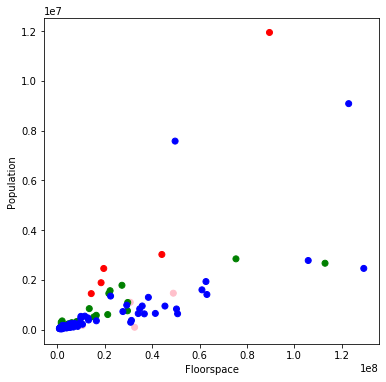

In [77]:
#floorspace per person
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(
    EIE_buildings[EIE_buildings.SECTOR=='Non-residential'].set_index('CITY').loc[EIE_general.CITY].FLOORSPACE,
    EIE_general.POPULATION.str.replace(',','').astype('float').values,
    c = EIE_general['color'].values
)
ax.set_ylabel('Population')
ax.set_xlabel('Floorspace')
plt.show()

In [78]:
EIE_buildings['FUEL_INTENSITY'] = EIE_buildings.ENERGY_INTENSITY * EIE_buildings.FUEL_FRAC

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


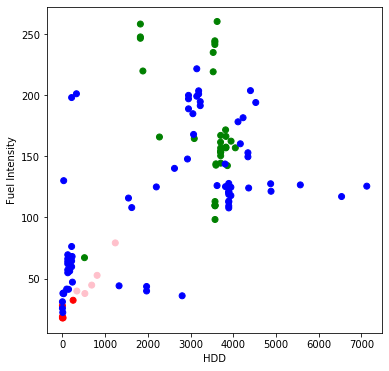

In [81]:
#hdd vs building energy
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(
    EIE_general.HDD,
    EIE_buildings[EIE_buildings.SECTOR=='Non-residential'].set_index('CITY').loc[EIE_general.CITY].FUEL_INTENSITY,
    c = EIE_general['color'].values
)
ax.set_ylabel('Fuel Intensity')
ax.set_xlabel('HDD')
plt.show()

In [89]:
#EIE_general = EIE_general.join(EIE_transport.groupby('CITY').EMISSIONS.sum(), on='CITY')
EIE_general = EIE_general.rename(columns={'EMISSIONS':'TRANSPORT_EMISSIONS'})

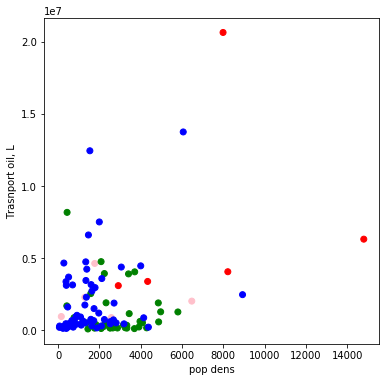

In [91]:
#transport vs pop dens
# petrol -> 2.3 kg/L
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(
    EIE_general.POP_DENS,
    EIE_general.TRANSPORT_EMISSIONS/2.3,
    c = EIE_general['color'].values
)
ax.set_ylabel('Trasnport oil, L')
ax.set_xlabel('pop dens')
plt.show()

In [ ]:
color by iea region:
hdd vs buildings
transport vs. pop density
pop dens vs floorspace

### Now do voronoi

In [19]:
def gen_pts_in_shp(number, polygon):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

In [8]:
import geovoronoi as gvo

In [9]:
ghsl_gdf[ghsl_gdf.CTR_MN_NM=='Italy'].iloc[0].UC_NM_MN

'Bolzano - Bozen'

In [14]:
area_shape = ne[ne.ADMIN=='Italy'] #.iloc[0].geometry

In [15]:
area_shape = area_shape.to_crs(epsg=3395).iloc[0].geometry

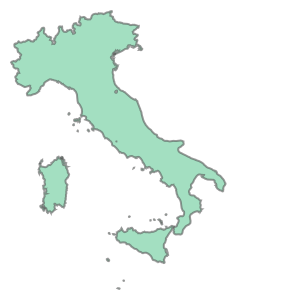

In [16]:
area_shape

In [36]:
area_shape.bounds

(735012.3535381783, 4205760.997690194, 2061350.4305617844, 5924686.54625782)

In [24]:
pts = gen_pts_in_shp(5,area_shape)

In [41]:
coords = np.array([[pt.x, pt.y] for pt in pts])

In [26]:
from geovoronoi import voronoi_regions_from_coords

In [42]:
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(coords, area_shape)

In [49]:
poly_to_pt_assignments

[[3], [1], [2], [0], [4]]

In [52]:
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

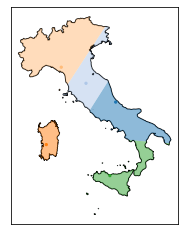

In [53]:
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, area_shape, poly_shapes, coords, poly_to_pt_assignments)
plt.show()

#### now do with real data

In [107]:
import geoplot

ModuleNotFoundError: No module named 'geoplot'

In [106]:
ghsl_gdf[ghsl_gdf.CTR_MN_NM=='Italy']

,ID_HDC_G0,QA2_1V,AREA,BBX_LATMN,BBX_LONMN,BBX_LATMX,BBX_LONMX,GCPNT_LAT,GCPNT_LON,CTR_MN_NM,...,EX_SS_P00,EX_SS_P15,EX_EQ19PGA,EX_EQ19MMI,EX_EQ19_Q,EX_HW_IDX,SDG_LUE9015,SDG_A2G14,SDG_OS15MX,geometry
810,2791,1,17,46.4518558989,11.3047389729,46.5077094757,11.3713555073,46.487720212,11.3365110803,Italy,...,0,0,0.096195,5,available,15.89710045,0.79137608029,0.320021698053,51.19,"MULTIPOLYGON (((11.32098 46.50771, 11.37136 46..."
833,2908,1,35,46.033627441,13.1813982429,46.117178649,13.2830418989,46.0753971745,13.2295322236,Italy,...,0,0,0.199321,6,available,12.94250011,1.72829101735,0.2372972264,46.86,"MULTIPOLYGON (((13.21345 46.11718, 13.23852 46..."
835,2779,1,24,46.033627441,11.0924345257,46.1264650179,11.1527427265,46.0750103639,11.1212996853,Italy,...,0,0,0.178911,5,available,24.85180092,0.682807259199,0.373052806375,65.97,"MULTIPOLYGON (((11.09596 46.12647, 11.12104 46..."
841,2881,1,29,45.9222987111,12.6015914234,45.9965086272,12.7195754367,45.9611583529,12.6594516516,Italy,...,0,0,0.198867,6,available,14.07549953,2.16402867761,0.287815029891,52.33,"MULTIPOLYGON (((12.69454 45.99651, 12.71958 45..."
846,2605,1,21,45.8203202065,9.34672244421,45.8759362305,9.42564483675,45.848787734,9.39189904383,Italy,...,0,0,0.103206,5,available,19.10210037,1.69636148711,0.268738804241,52.64,"MULTIPOLYGON (((9.40163 45.87594, 9.41413 45.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,3056,1,36,37.5433533291,15.047577154,37.6316900645,15.1755413102,37.5988045697,15.1308429736,Italy,...,0,0,0.312001,6,available,8.665599823,1.71710682577,0.17973806295,61.31,"MULTIPOLYGON (((15.07288 37.63169, 15.08441 37..."
2043,3051,1,109,37.4727122274,14.9892383331,37.5875167774,15.1423744559,37.5344813077,15.0715296104,Italy,...,0,0,0.378478,7,available,8.665599823,-1.01705076222,0.12243099955,49.37,"MULTIPOLYGON (((15.04423 37.58752, 15.12493 37..."
2134,3074,1,24,37.0493890416,15.2443941024,37.1110681483,15.3051230887,37.0820619349,15.2777038012,Italy,...,0,0,0.267528,6,available,8.987050056,-0.523165477049,0.00943263729476,47.42,"MULTIPOLYGON (((15.28327 37.11107, 15.29475 37..."
2137,3014,1,22,37.0405792784,14.1987557179,37.0846319374,14.2895464983,37.0666092336,14.2472309897,Italy,...,0,0,0.164229,5,available,NAN,1.39930731759,0.0317157058699,46.64,"MULTIPOLYGON (((14.20082 37.08463, 14.25822 37..."


In [56]:
coords_dict = {}
for row in ghsl_gdf[ghsl_gdf.CTR_MN_NM=='Italy'].to_crs(epsg=3395).iterrows():
    name = row[1].UC_NM_MN
    geom = row[1].geometry

    coords_dict[name] = []
    for subgeom in list(geom):
        coords_dict[name]+=subgeom.exterior.coords

In [57]:
n_coords = sum([len(vv) for kk,vv in coords_dict.items()])

In [68]:
vor_coords = np.zeros((n_coords,2))

In [69]:
bmark=0
for ii_k,(kk,vv) in enumerate(coords_dict.items()):
    vor_coords[bmark:bmark+len(vv),:] = np.array(vv)
    bmark+=len(vv)

In [70]:
vor_coords

array([[1260246.18020579, 5831074.47352369],
       [1265853.50470059, 5831074.47352369],
       [1265580.88472786, 5828072.91812245],
       ...,
       [1636203.5281382 , 4403136.52253122],
       [1634927.23833466, 4403136.52253122],
       [1635045.14592143, 4404357.41805818]])

In [97]:
from geovoronoi import polygon_lines_from_voronoi,polygon_shapes_from_voronoi_lines, coords_to_points, assign_points_to_voronoi_polygons
from scipy.spatial import Voronoi

In [83]:
vor = Voronoi(vor_coords)

In [87]:
vor

In [88]:
poly_lines = polygon_lines_from_voronoi(vor, area_shape)

In [89]:
poly_shapes = polygon_shapes_from_voronoi_lines(poly_lines, area_shape)

In [100]:
points = coords_to_points(vor_coords)

In [95]:
poly_shapes_ne = [pp for pp in poly_shapes if not pp.is_empty]

In [124]:
geoms = [row[1].geometry for row in ghsl_gdf[ghsl_gdf.CTR_MN_NM=='Italy'].to_crs(epsg=3395).iterrows()]

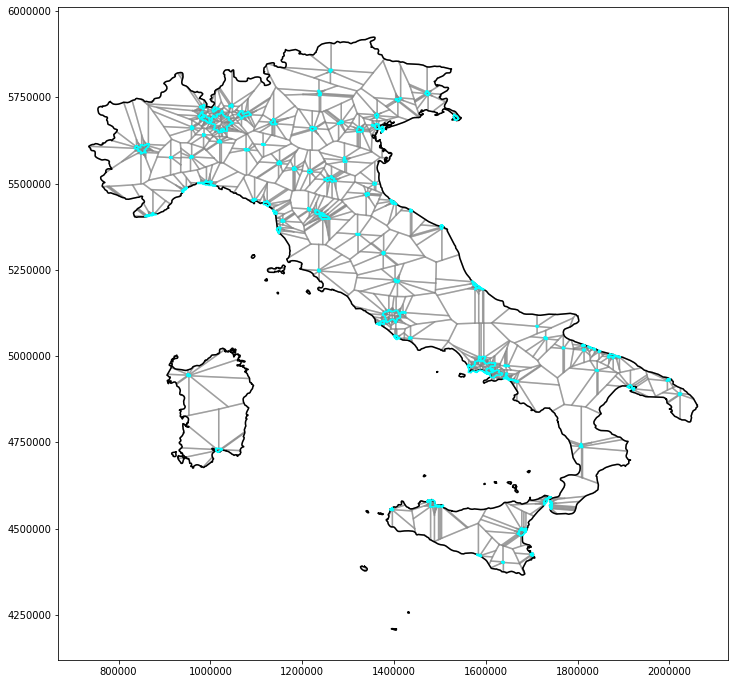

In [116]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

for shp in poly_shapes_ne:
    if shp.type=='Polygon':
        xs,ys = shp.exterior.xy
        ax.plot(xs,ys,c='gray', alpha=0.5)
    elif shp.type=='MultiPolygon':
        for subshp in list(shp):
            xs,ys = subshp.exterior.xy
            ax.plot(xs,ys, c='gray',alpha=0.5)
            
for shp in list(area_shape):
    xs,ys = shp.exterior.xy
    ax.plot(xs,ys,c='k', alpha=1.0)
    
for shp in geoms:
    for subshp in list(shp):
        xs,ys = subshp.exterior.xy
        ax.plot(xs,ys,c='cyan', alpha=1.0)
        
plt.show()

In [119]:
from shapely.strtree import STRtree
from shapely.ops import cascaded_union

In [118]:
tree = STRtree(poly_shapes_ne)

In [121]:
geoms_dict = {}
for row in ghsl_gdf[ghsl_gdf.CTR_MN_NM=='Italy'].to_crs(epsg=3395).iterrows():
    name = row[1].UC_NM_MN
    geoms_q = tree.query(row[1].geometry)
    geoms_q.append(row[1].geometry)
    print (name,len(geoms_q))
    geoms_dict[name] = cascaded_union(geoms_q)

Bolzano - Bozen 15
Udine 27
Trento 22
Pordenone 28
Lecco 20
Varese 27
Como 36
Bergamo 67
Treviso 22
Triest 27
Gallarate 45
Busto Arsizio 64
Brescia 35
Vicenza 28
Mestre 34
Novara 20
Verona 26
Padua 32
Milan 177
Venice 21
Vigevano 11
Pavia 21
Cremona 7
Piacenza 14
Turin 82
Asti 9
Alessandria 18
Ferrara 20
Parma 23
Reggio nell'Emilia 23
Modena 21
Bologna 58
Genoa 43
Ravenna 12
Savona 21
Forlì 23
La Spezia 20
Rimini 31
Massa 27
Pistoia 13
Pesaro 11
Viareggio 15
Prato 50
Florence 62
Sanremo 27
Pisa 19
Ancona 18
Livorno 22
Arezzo 11
Perugia 19
Grosseto 13
Terni 27
Pescara 66
Tivoli 15
Rome 119
Acilia 35
Lido di Ostia 15
San Severo 7
Anzio 24
Foggia 11
Latina 12
Barletta 17
Trani 14
Cerignola 10
Bisceglie 10
Andria 11
Molfetta 12
Bari 48
Caserta 35
Avellino 14
San Giuseppe Vesuviano 18
Altamura 13
Sassari 19
Naples 195
Salerno 48
Battipaglia 22
Brindisi 14
Taranto 32
Lecce 13
Cosenza 20
Cagliari 21
Messina 54
Palermo 53
Bagheria 12
Reggio Calabria 35
Trapani 21
Acireale 39
Catania 38
Syracus

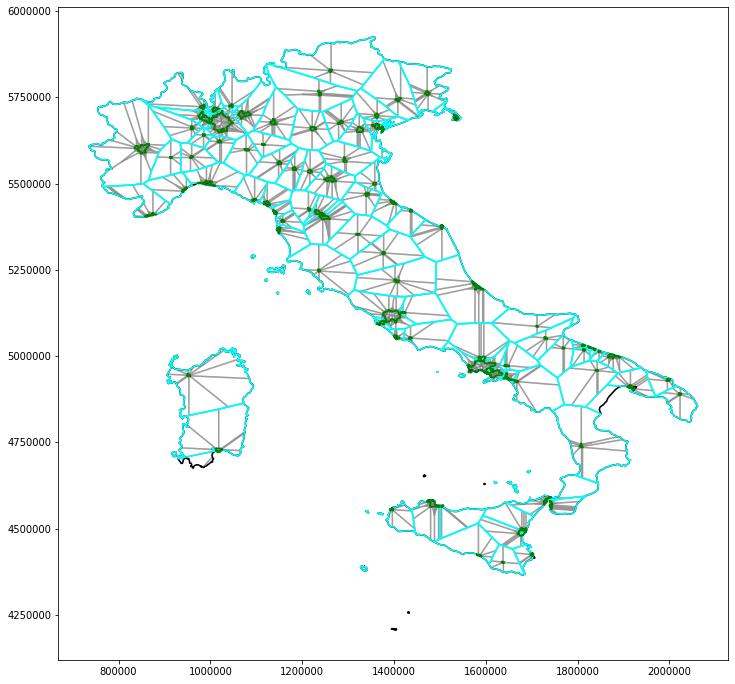

In [125]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

for shp in poly_shapes_ne:
    if shp.type=='Polygon':
        xs,ys = shp.exterior.xy
        ax.plot(xs,ys,c='gray', alpha=0.5)
    elif shp.type=='MultiPolygon':
        for subshp in list(shp):
            xs,ys = subshp.exterior.xy
            ax.plot(xs,ys, c='gray',alpha=0.5)
            
for shp in list(area_shape):
    xs,ys = shp.exterior.xy
    ax.plot(xs,ys,c='k', alpha=1.0)

for kk, vv in geoms_dict.items():
    if vv.type=='Polygon':
        xs,ys = vv.exterior.xy
        ax.plot(xs,ys,c='cyan', alpha=1.0)
    elif vv.type=='MultiPolygon':
        for subshp in list(vv):
            xs,ys = subshp.exterior.xy
            ax.plot(xs,ys,c='cyan', alpha=1.0)
            
for shp in geoms:
    for subshp in list(shp):
        xs,ys = subshp.exterior.xy
        ax.plot(xs,ys,c='g', alpha=1.0)
        
plt.show()